In [34]:
import re
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
import jieba

In [58]:
poems = []
with open('data.csv', 'r', encoding='utf-8') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        if random.random() < 0.1:
            poem_content = row['content']
            poems.append(poem_content)

In [59]:
# 使用jieba分词，并跳过标点符号和换行符
poems = [list(filter(lambda x: x not in ['\n', '，', '。', '！', '？','、'], jieba.cut(poem))) for poem in poems]


# 将列表的列表展平，得到词列表
words = [word for poem in poems for word in poem]

# 去重以构建词汇表
vocab = set(words)

In [61]:
# 长度就是模型接受的大小
vocab_size = len(vocab)
# 加密解密
char_to_index = {char: i for i, char in enumerate(vocab)}
index_to_char = {i: char for i, char in enumerate(vocab)}

# 模型参数初始化
input_size = vocab_size
hidden_size = 5 # 可以调整这个值以优化模型
output_size = vocab_size
rate = 0.05

Wxh = np.random.randn(hidden_size, input_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(output_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

In [62]:
# 前向和后向传播
def forward_backward(inputs, targets, hprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    # RNN通过上一次的h与x共同作用
    hs[-1] = np.copy(hprev)
    loss = 0

    for t in range(len(inputs)):
        xs[t] = np.zeros((input_size, 1))
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += -np.log(ps[t][targets[t], 0])

    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        dhraw = (1 - hs[t] * hs[t]) * dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)

    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [64]:
# 每五个为一个序列
length = 25
# 训练参数
num = 100000  # 迭代次数
patience = 800   # 耐心值

In [65]:
def train(data, num, patience=500):
    global Wxh, Whh, Why, bh, by  # 全局

    lowest_loss = np.inf # 迭代找最小
    best = {}
    counter = 0

    n, p = 0, 0
    hprev = np.zeros((hidden_size, 1))
    losses = [] # 记录loss
    lossess = []
    for i in range(num):
        if p + length + 1 >= len(data) or n == 0:
            hprev = np.zeros((hidden_size, 1))
            p = 0  

        inputs = [char_to_index[data[p]]]
        targets = [char_to_index[ch] for ch in data[p+1:p+length+1]]

        loss, dWxh, dWhh, dWhy, dbh, dby, hprev = forward_backward(inputs, targets, hprev)

        # 梯度下降
        for param, dparam in zip([Wxh, Whh, Why, bh, by], [dWxh, dWhh, dWhy, dbh, dby]):
            param += -rate * dparam

        p += length  
        n += 1  
        if n%10 ==0:
            lossess.append(loss)
        if n % 5000 == 0:
            print(f"Epoch {n}, Loss: {loss}")
            losses.append(loss)
        
        if loss < lowest_loss:
            lowest_loss = loss
            best = {
                'Wxh': Wxh.copy(), 
                'Whh': Whh.copy(), 
                'Why': Why.copy(), 
                'bh': bh.copy(), 
                'by': by.copy()
            }
            counter = 0
        else:
            counter += 1

        # if counter > patience:
        #     print(f"Early stopping at iteration {n}, Lowest loss: {lowest_loss}")
        #     break

    Wxh, Whh, Why, bh, by = best.values()
    plt.plot(range(len(losses)),losses)
    plt.xlabel('num')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    plt.scatter(range(len(lossess)), lossess, color='red', marker='o')
    plt.xlabel('num')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    return best, lowest_loss

Epoch 5000, Loss: 4.373574523078004
Epoch 10000, Loss: 4.2746594858021485
Epoch 15000, Loss: 4.054186879911048
Epoch 20000, Loss: 3.9553125011606816
Epoch 25000, Loss: 3.948721381827532
Epoch 30000, Loss: 2.9303082816005306
Epoch 35000, Loss: 3.150541840449093
Epoch 40000, Loss: 2.280740842457477
Epoch 45000, Loss: 1.9469633172297927
Epoch 50000, Loss: 0.7309052838589235
Epoch 55000, Loss: 0.6468008274512094
Epoch 60000, Loss: 0.4722407753351374
Epoch 65000, Loss: 0.3373154896989249
Epoch 70000, Loss: 0.20040986876769418
Epoch 75000, Loss: 0.14916613857493127
Epoch 80000, Loss: 0.2802972026518197
Epoch 85000, Loss: 0.17659769659217917
Epoch 90000, Loss: 0.08686136031908726
Epoch 95000, Loss: 0.05990667147895154
Epoch 100000, Loss: 0.28837428739811916


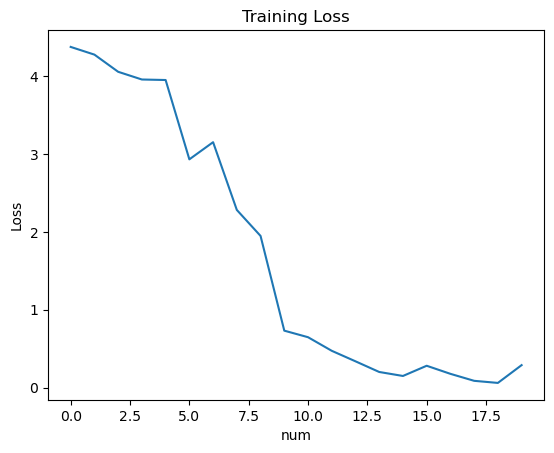

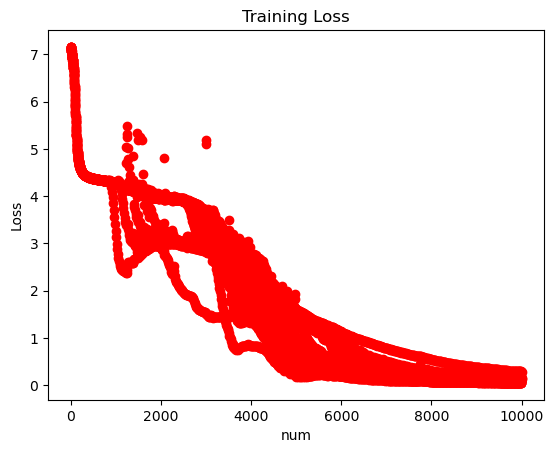

lowest loss: 0.015067763723342268


In [66]:

best_params, lowest_loss = train(words, num, patience)

print(f"lowest loss: {lowest_loss}")

In [67]:
def generate_line(start_word, length=5):

    if start_word not in char_to_index:
        # 如果起始词不在词汇表中，随机选择一个词
        random_word = np.random.choice(list(vocab))
        start_index = char_to_index[random_word]
    else:
        start_index = char_to_index[start_word]

    x = np.zeros((input_size, 1))
    x[start_index] = 1
    h = np.zeros((hidden_size, 1))
    indices = [start_index]  

    for _ in range(length - 1): 
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y_hat = np.dot(Why, h) + by
        prob = np.exp(y_hat) / np.sum(np.exp(y_hat))
        next_index = np.random.choice(range(vocab_size), p=prob.ravel())
        indices.append(next_index)
        x = np.zeros((input_size, 1))
        x[next_index] = 1

    generated_poem = "".join(index_to_char[i] for i in indices)
    return generated_poem

In [68]:
# 输入藏头词列表
acrostic_input = input("请输入藏头诗的头: ").split(' ')

for word in acrostic_input:
    generated_line = generate_line(word, length=3)
    print(generated_line)

春露湿华发
